# BCDP CMIP6 Example
## Quick Overview
Here we will do a quick walkthrough of using BCDP to process some regional climate simulations from the Coordinate Regional Downscaling Experiment

In [1]:
import os
import glob
import numpy as np
import bcdp
import matplotlib.pyplot as plt

Create a file conventions template. Here we only need the model and variable names so the rest of the file template is filled in by wildcards.

In [6]:
# Dataset Options
variable_id = 'tas'
experiment_id = 'historical'
table_id = 'Amon'
member_id = 'r1i1p1f1'
grid_label = 'gn'
activity_id = 'CMIP'
institution_id = 'NCAR'

# Processing Options
backend = 'scipy'
method = 'linear'
res = (0.88, 0.88)
freq = 'A'
lat_bnds = None
lon_bnds = None
time_bnds = None
season = None

# Output
nc_file = 'CMIP_example.nc' # type: stage-out
plot_file = 'CMIP_example.png' # type: stage-out

Load the data. Because we have loaded the template, the loader now knows exactly how to extract the required informations from the filenames.

In [7]:
if isinstance(res, str):
    res = res.split(',')
if isinstance(lat_bnds, str):
    lat_bnds = lat_bnds.split(',')
if isinstance(lon_bnds, str):
    lon_bnds = lon_bnds.split(',')
if isinstance(time_bnds, str):
    time_bnds = time_bnds.split(',')
    
query = dict(variable_id=variable_id, experiment_id=experiment_id, 
             table_id=table_id, member_id=member_id, grid_label=grid_label, 
             institution_id=institution_id, activity_id=activity_id)
zarr_kwargs = dict(consolidated=True)
ens = bcdp.load_intake_esm(query, zarr_kwargs=zarr_kwargs)
print(ens.size)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


1.09GB


/Users/goodman/opt/envs/py37/lib/python3.7/site-packages/xarray/core/dataarray.py:3268: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


The loader returns an `Ensemble` object, which is essentially a collection of datasets and applies preprocessing operations to each of them. Here we will regrid the data to a coarser (0.88 degree) grid using bilinear interpolation, and consider only the winter months (DJF).

In [8]:
domain = bcdp.Bounds(lat_bnds=lat_bnds, lon_bnds=lon_bnds, time_bnds=time_bnds)
output_grid = bcdp.utils.grid_from_res(res, domain)
ens_u = ens.homogenize(backend=backend, method=method, freq=freq,
                       output_grid=output_grid, clean=False)

Now that the underlying datastructures are homogeneous (same grid and time step), we can convert it to an xarray dataarray which has dimensions (names, time, lat, lon).

In [23]:
def show_ens(ens, nc_file, plot_file):
    #da = ens.bundle('Temperature').add_mean('CMIP6').first
    da = ens.bundle('Temperature').first
    da.to_netcdf(nc_file)
    plt.figure()
    da.mean('time').plot(x='x', y='y', col='names', col_wrap=3)
    plt.savefig(plot_file)

We can easily visualize the annual climatology with xarray's built-in plotting methods.

<Figure size 432x288 with 0 Axes>

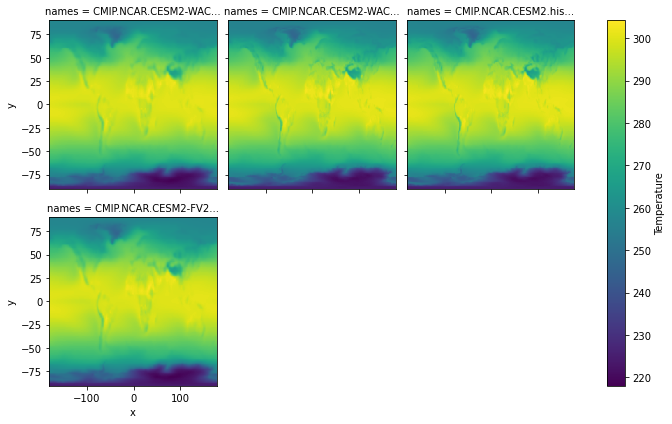

In [24]:
show_ens(ens_u, nc_file, plot_file)